## Brainstorming the HRML PD/ICE plotting functionality.

In [1]:
"""
Patrick's original functions
"""

def pd_ice(x_name, valid, model, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
    :param x_name: Variable for which to calculate partial dependence.
    :param valid: Pandas validation frame.
    :param model: H2O model (assumes binary classifier).
    :param resolution: The number of points across the domain of xs for which
                       to calculate partial dependence, default 20.
    :param bins: List of values at which to set xs, default 20 equally-spaced
                 points between column minimum and maximum.
    :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

        # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    # this could be abstracted to an input callable to support multiple model architectures.
    temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()


def get_percentile_dict(yhat_name, valid, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
    :param yhat_name: Name of column in valid in which to find percentiles.
    :param valid: Pandas validation frame.
    :param id_: Validation Pandas frame containing yhat and id_.
    :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = valid.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict


def plot_pd_ice(x_name, par_dep_frame, ax=None):

    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    :param x_name: Name of variable for which to plot ICE and partial dependence.
    :param par_dep_frame: Name of Pandas frame containing ICE and partial
                          dependence values (tightly coupled to frame schema).
    :param ax: Matplotlib axis object to use.
    """

    # for standalone plotting
    if ax is None:

        # initialize figure and axis
        fig, ax = plt.subplots()

        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='grey',
                           linewidth=3,
                           ax=ax)

    # for grouped subplots
    else:

        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)

        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='red',
                           linewidth=3,
                           ax=ax)


def hist_mean_pd_ice_plot(x_name, y_name, valid, pd_ice_dict):

    """ Plots diagnostic plot of histogram with mean line overlay
        side-by-side with partial dependence and ICE.
    :param x_name: Name of variable for which to plot ICE and partial dependence.
    :param y_name: Name of target variable.
    :param valid: Pandas validation frame.
    :param pd_ice_dict: Dict of Pandas DataFrames containing partial dependence
                        and ICE values.
    """

    # initialize figure and axis
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1.8, wspace=0.18)

    # if variable is *not* high cardinality
    # create histogram directly
    if valid[x_name].nunique() <= 20:
        mean_df = valid[[x_name, y_name]].groupby(by=x_name).mean()
        freq, bins, _ = ax.hist(valid[x_name], color='k')

    # if variable is high cardinality
    # bin, then create hist
    else:
        temp_df = pd.concat([pd.cut(valid[x_name], pd_ice_dict[x_name][x_name] - 1, duplicates='drop'),
                             valid[y_name]], axis=1)
        mean_df = temp_df.groupby(by=x_name).mean()
        del temp_df
        freq, bins, _ = ax.hist(valid[x_name], bins=pd_ice_dict[x_name][x_name] - 1, color='k')
        bins = bins[:-1]

    # annotate hist
    ax.set_xlabel(x_name)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Mean ' + y_name + ' Overlay')

    # create a new twin axis
    # on which to plot a line showing mean value
    # across hist bins
    ax1 = ax.twinx()
    _ = ax1.set_ylim((0, 1))
    _ = ax1.plot(bins, mean_df.reindex(labels=bins)[y_name], color='r')
    _ = ax1.set_ylabel('Mean ' + y_name)
    _ = ax1.legend(['Mean ' + y_name], loc=1)

    # plot PD and ICE
    plot_pd_ice(x_name,
                pd_ice_dict[x_name],
                ax2)
    _ = ax2.legend(bbox_to_anchor=(1.05, 0),
                   loc=3,
                   borderaxespad=0.)

### Train a model for testing

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Data/credit_line_increase.csv')

seed = 12345
np.random.seed(seed)

# Generate train/test/validation datasets

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

dtrain = xgb.DMatrix(train[features], 
                     label=train[target])

dvalid = xgb.DMatrix(valid[features], 
                     label=valid[target])

# Feed the model the global bias
base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_unconstrained = xgb.train(params,         
                                dtrain,                   
                                num_boost_round=200,                     
                                evals=watchlist,
                                early_stopping_rounds=10,
                                verbose_eval=False)

### Testing explain module after refactoring

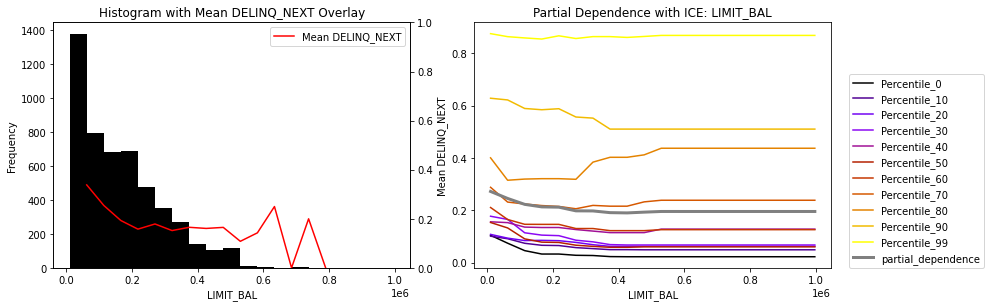

In [5]:
from explain import plot_partial_dep_ice

my_predict = lambda data: model_unconstrained.predict(xgb.DMatrix(data[features], label=data[target]))

plot_partial_dep_ice(feature='LIMIT_BAL', 
                     X=valid[features], 
                     y=valid[target], 
                     predict=my_predict)


### Prototying some refactoring

This implementation is model-agnostic, the user just bring a 'predict' callable. We'll use this for testing the original implementation using our unconstrained XGBoost model. 

In [4]:
def pd_ice_new(x_name, valid, predict, resolution=20, bins=None):

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        valid.loc[:, x_name] = bins[j]
        temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache
    temp_df['partial_dependence'] = my_predict(temp_df)

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

### Intended Usage (originally)

We're going to refactor this.

In [5]:
pd_ice_dict = {}

for feat in features: 
    pd_ice_dict[feat] = pd_ice_new(feat, valid, my_predict)

In [6]:
# merge predictions onto test data
valid['p_DELINQ_NEXT'] = model_unconstrained.predict(dvalid)
percentile_dict = get_percentile_dict('p_DELINQ_NEXT', valid, 'ID')

# for pctile, id_ in percentile_dict.items():
#     print(f"{pctile}: {valid.loc[valid['ID'] == id_]['p_DELINQ_NEXT'].values[0]}")

# key=percentile, val=row_id
percentile_dict

{0: 5460,
 99: 24168,
 10: 27883,
 20: 23693,
 30: 12199,
 40: 27042,
 50: 18417,
 60: 17402,
 70: 7265,
 80: 27067,
 90: 6286}

In [7]:
# loop through selected variables
for feat in features: 

    # collect bins used in partial dependence
    bins = list(pd_ice_dict[feat][feat])
    
    # calculate ICE at percentiles using partial dependence bins for each feature
    for i in sorted(percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        pd_ice_dict[feat][col_name] = pd_ice_new(feat,
                                                 valid[valid['ID'] == int(percentile_dict[i])], 
                                                 my_predict, 
                                                 bins=bins)['partial_dependence']
       

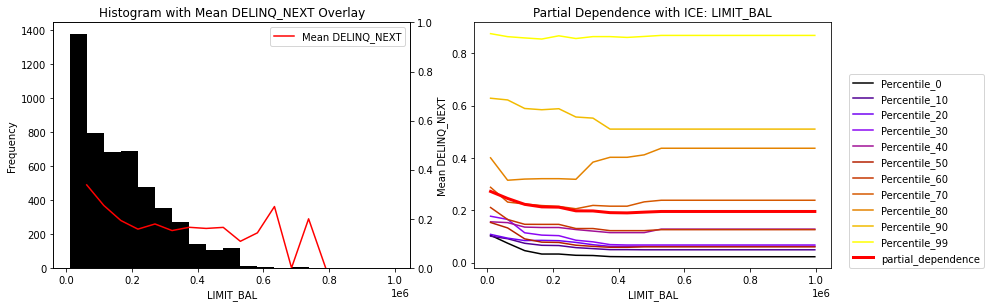

In [8]:
hist_mean_pd_ice_plot(features[0], target, valid, pd_ice_dict)

### Real refactor

What do we want the interface to look like? One possibility is:

> `plot_partial_dep_ice(feature, X, y, predict)`

Where `predict` is a callable that takes a dataset argument and returns a np.ndarray or pd.Series. First I'll do an ugly refactor of the existing code to implement this interface. 

In [9]:
def plot_partial_dep_ice(feature, X, y, predict):

    X[y.name] = y
    
    # there's a redundant call to predict here.
    pd_ice_data = pd_ice_new(feature, X, predict)
    preds = predict(X)
        
    # create a copy of frame and sort it by yhat
    sort_df = X.copy(deep=True)
    sort_df['prediction'] = preds
    sort_df.sort_values('prediction', inplace=True)
    
    # sort_df.reset_index(inplace=True)
    # Use the native pandas index rather than the id column
    
    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.index[0], 99: sort_df.index[-1]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.index[i * inc]
        
    # collect bins used in partial dependence
    bins = list(pd_ice_data[feature])
    
    # calculate ICE at percentiles using partial dependence bins for each feature
    for pctile in sorted(percentiles_dict.keys()):
        col_name = 'Percentile_' + str(pctile)
        pd_ice_data[col_name] = pd_ice_new(feature,
                                           X.loc[[int(percentiles_dict[pctile])]], 
                                           my_predict, 
                                           bins=bins)['partial_dependence']
        
    hist_mean_pd_ice_plot(feature, y.name, X, {feature: pd_ice_data})
    return

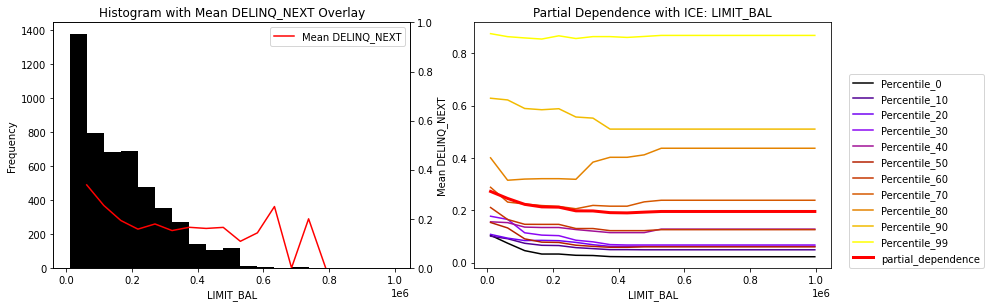

In [10]:
X = valid[features]
y = valid[target]
feature = features[0]
predict = my_predict

plot_partial_dep_ice(feature, X, y, predict)
